In [29]:
import sympy
from sympy import I, re, im
from sympy.parsing.sympy_parser import (parse_expr, standard_transformations,
                                        implicit_multiplication_application,convert_xor)
from IPython.display import display
sympy.init_printing(use_latex='mathjax')
import numpy as np
np.set_printoptions(suppress=True)
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, generate_preset_pass_manager, transpile
from qiskit_ibm_runtime import SamplerV2 as Sampler, EstimatorV2 as Estimator, QiskitRuntimeService
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
import pyqsp
from pyqsp.poly import PolyTaylorSeries
from sympy.functions.special.polynomials import chebyshevt
from scipy.optimize import minimize


In [31]:
try:
    # --- Get User Input ---
    func_str = input("Enter the function to integrate (e.g., sin(x) * exp(-x)): ")
    lower_limit_str = input("Enter the lower limit of integration (e.g., 0): ")
    upper_limit_str = input("Enter the upper limit of integration (e.g., pi): ")

    # --- Define the single, expected symbolic variable ---
    x = sympy.symbols('x', real=True)
    expected_symbols = {x}

    # --- Safely Parse the Function String ---
    local_dict = {'x': x}
    global_dict = sympy.__dict__
    transformations = standard_transformations + (implicit_multiplication_application, convert_xor)
    func_expr = parse_expr(func_str,
                           local_dict=local_dict,
                           global_dict=global_dict,
                           transformations=transformations)

    # --- THE CRUCIAL VALIDATION STEP ---
    found_symbols = func_expr.free_symbols
    if not found_symbols.issubset(expected_symbols):
        unknown_symbols = found_symbols - expected_symbols
        raise ValueError(f"Function contains unknown variables: {unknown_symbols}. "
                         f"The expression must only depend on 'x'.")

    # --- Finalize Inputs ---
    lower_limit = sympy.sympify(lower_limit_str)
    upper_limit = sympy.sympify(upper_limit_str)

    func = sympy.simplify(func_expr)
    
    # --- Display the problem ---
    integral_expr = sympy.Integral(func, (x, lower_limit, upper_limit))
    print("\nEntered definite integral Mathematical expression:")
    display(integral_expr)

    # Convert limits to floats to prevent constants parsing errors
    try:
        lower_limit_f = float(lower_limit)
        upper_limit_f = float(upper_limit)
    except TypeError:
        lower_limit_f = float(lower_limit.evalf())
        upper_limit_f = float(upper_limit.evalf())

    lower_limit=lower_limit_f
    upper_limit= upper_limit_f
except Exception as e:
    print(f"\nError: Could not process the input. Please check the expression. \nDetails: {e}")






Entered definite integral Mathematical expression:


10          
⌠           
⎮  log(x) dx
⌡           
1           

In [ ]:
def getChebyshevPolynomial(symbol, function, degree, lower_limit, upper_limit,max_scale):
    """
    Generates a Chebyshev polynomial approximation for a given SymPy function.
    """
    print(f"Chebyshev APPROXIMATION to {degree}th degree : ")


    # Create a numerical version of the original function f(x).
    f_numeric = sympy.lambdify(symbol, function, 'numpy')

    # Define the transformed function g(y) for the interval [-1, 1].
    jac_scaling = (upper_limit - lower_limit) / 2.0
    offset = (upper_limit + lower_limit) / 2.0
    
    # This g(y) is now a purely numerical function, as required by SciPy.
    g = lambda y: f_numeric(jac_scaling * y + offset) * jac_scaling
    
    # Find the maximum absolute value of g(y) for scaling.
    # -|g(y)| because min of that is max of g(y)
    res = minimize(lambda y: -np.abs(g(y)), x0=0, bounds=[(-1, 1)])
    max_g_val = -res.fun

    # Generate the Chebyshev polynomial approximation of the core function f(x)
    # The function passed to pyqsp must also be purely numerical.
    # Approximate the function f(...) without the jac_scaling factor.
    func_to_approximate = lambda y: f_numeric(jac_scaling * y + offset)
    
    poly_chebyshev = PolyTaylorSeries().taylor_series(
        func=func_to_approximate,
        degree=degree,
        max_scale=max_scale,
        chebyshev_basis=True,
        cheb_samples=2 * degree
    )
    
    # The scaling factor M should be 4 * max(|f(x)|) on the original interval.
    # max(|g(y)|) = max(|f(x)|) * jac_scaling.
    # So, max(|f(x)|) = max_g_val / jac_scaling.
    M = (max_g_val / jac_scaling) * 4.0 if jac_scaling != 0 else max_g_val * 4.0
    print(f"M value for scaling is: {M:.4f}")

    y_sym = sympy.Symbol('y')
    coeffs = poly_chebyshev.coef
    
    # The polynomial approximates f(...), so we multiply by jac_scaling for the integral.
    chebyshev_sympy_expr = jac_scaling * sum(coeffs[i] * chebyshevt(i, y_sym) for i in range(len(coeffs)))

    integration_expr = sympy.Integral(chebyshev_sympy_expr, (y_sym, -1, 1))
    print("\nApproximated Integral (Chebyshev Polynomial on [-1, 1]):")
    display(integration_expr)

    return coeffs, M,chebyshev_sympy_expr

In [ ]:
# Discretize func_expr
def discretize(f_callable,lower_limit, upper_limit,N):
    upper_limit= float(upper_limit)
    lower_limit= float(lower_limit)
    
    #f_callable= sympy.lambdify(x, func, 'numpy')

    # N random X points such that there are N random F(x). Sigma F(x) deltaX is integral (RIEMANN SUM)
    x_array = np.random.uniform(lower_limit,upper_limit,N)
    y_array= f_callable(x_array)
   
    return y_array,x_array 

def IntegrateClassical(y_arr,lower_limit, upper_limit,N):
    
    total_sum= np.sum(y_arr, dtype= float)

    # Average
    Classical_integral=total_sum/N

    return Classical_integral

In [2]:
# Degree of Approximation
d= 14
num_qubits=13
N=2**num_qubits

In [132]:
g_numerical = sympy.lambdify(sympy.symbols('y',real=True),
                              chebyshev_Polynomial, 'numpy')

y_classical, x_array_classical=discretize(g_numerical,-1,1,N)

# Scale y with y_classical*2
y_classical= (y_classical*(M/4))/4
answer= IntegrateClassical(y_classical,-1,1,N)


print("Y Array:")
print(y_classical)


print("\nClassical Integration Answer:")
# Un-Scale
answer*=M
print(answer)

Y Array:
[1.94997643 1.72506074 0.26910872 ... 0.85242051 1.60684288 1.2013302 ]

Classical Integration Answer:
14.496695919094902


The Original Function F_callable is assumed to be the ideal in 2^14 samples to show almost continuous function plot.
This is because present QPUs can't run this algorithm for 14 qubits and the simulation is quite resource intensive.

Chebyshev_polynomial_expr is the approximated chebyshev polynomial from the original f(x)
    This polynomial is approximated to the dth degree and N= 2**n samples.
    The plots of this polynomial are in Green Color.


Quantum Loaded Plots are in Blue Color.
 


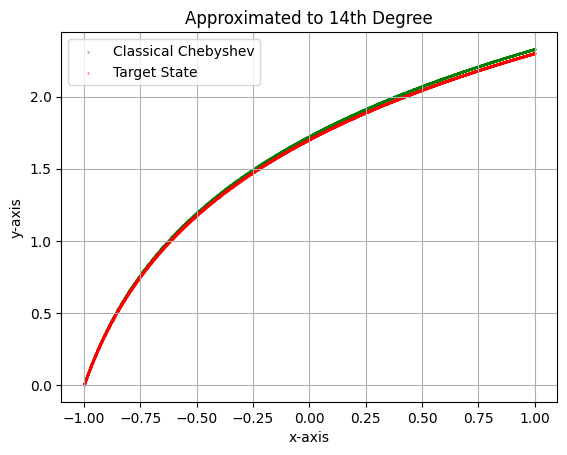

In [124]:
# Create a numerical version of the original function f(x).
f_numerical = sympy.lambdify(x, func, 'numpy')
jac_scaling = (upper_limit - lower_limit) / 2.0
offset = (upper_limit + lower_limit) / 2.0
f_ideal_callable = lambda y: f_numerical(jac_scaling * y + offset)

y,x_array= discretize(f_ideal_callable,-1,1,2**14)

plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.title(f"Approximated to {d}th Degree")
plt.scatter(x_array_classical,y_classical,
             color='green', label='Classical Chebyshev',s=0.1)
plt.scatter(x_array,y,
            color='red',label='Target State', s=0.1)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
plt.xlabel("x-axis")
plt.ylabel("y-axis")

plt.title(f"Error of{d}th Degree")



In [ ]:
chebyshev_coeffs, M,chebyshev_Polynomial = getChebyshevPolynomial(x,func, d, lower_limit, upper_limit,0.25)

print(f"The Chebyshev polynomial {len(chebyshev_coeffs)} coefficients to encode on Quantum Circuit are: ")
print(chebyshev_coeffs)


Chebyshev APPROXIMATION to 14th degree : 
[PolyTaylorSeries] (Cheb) max 0.39086585847364935 is at 1.0: normalizing
[PolyTaylorSeries] (Cheb) average error = 1.8345456924041132e-06 in the domain [-1, 1] using degree 14
M value for scaling is: 9.2103

Approximated Integral (Chebyshev Polynomial on [-1, 1]):


1                                                                              ↪
⌠                                                                              ↪
⎮  ⎛                     14                     13                      12     ↪
⎮  ⎝- 0.214613945739972⋅y   + 0.22244990000608⋅y   + 0.519204398914016⋅y   - 0 ↪
⌡                                                                              ↪
-1                                                                             ↪

↪                                                                              ↪
↪                                                                              ↪
↪                   11                      10                      9          ↪
↪ .479426794209871⋅y   - 0.594832846745593⋅y   + 0.509715120669933⋅y  + 0.2674 ↪
↪                                                                              ↪
↪                                                                              ↪

↪                         

The Chebyshev polynomial 15 coefficients to encode on Quantum Circuit are: 
[ 0.5729431   0.40610482 -0.10548448  0.03653236 -0.01423375  0.00591548
 -0.00256088  0.00114031 -0.00051834  0.00023935 -0.00011191  0.00005285
 -0.00002517  0.00001207 -0.00000582]


In [ ]:
def walsh_loader(qc,Qbit,ancilla,y,N):
    # Min-Max scale y
    y= y
    wh_transform=np.array(sympy.fwht(y), dtype=float)/np.sqrt(N)

    
    print("THIS IS Y L2 NORMALIZED")
    print(y)

    print("THIS IS AFTER APPLYING FWHT")
    print(wh_transform)

    return qc

In [ ]:
Qbit= QuantumRegister(num_qubits,name='logical')
Cbit= ClassicalRegister(num_qubits,name='result')
ancilla= QuantumRegister(3,name='anc')

qc= QuantumCircuit(Qbit,ancilla,Cbit)
#Equal Superposition


#qc= walsh_loader(qc,Qbit,ancilla,,N)

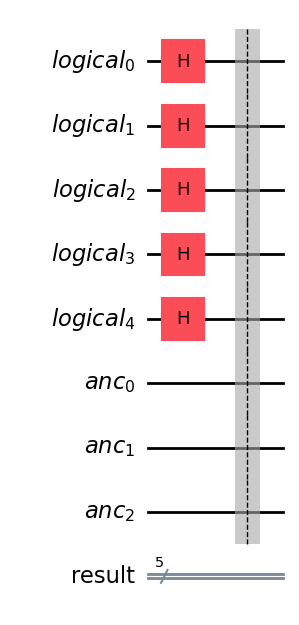

In [86]:
qc.draw('mpl')

In [ ]:
service = QiskitRuntimeService(name="qiskit_adi")
# Get a backend
backend = AerSimulator()
#backend = service.least_busy(operational=True, simulator=False)
#backend= service.backend(name='ibm_torino')
print(f"We are using the {backend.name} quantum computer")
shots= 1024
sampler = Sampler(mode=backend)